# Assignment 1. Pruning for CNN

## Goals

본 실습은 CNN 모델의 다양한 Pruning 기법을 이해하고, 이를 구현하여 각 방법이 모델의 정확도와 효율성에 어떤 영향을 주는지 확인하는 것을 목표로 합니다.


## Contents

1. **Pruning Granularity:**
    - Fine-grained, Vector-level, Kernel-level, Channel-level의 차이를 학습하고 구현합니다.
2. **Pruning Ratio:**
    - 제거할 가중치의 비율(Sparsity)을 결정하는 방법을 배웁니다. Layer-wise와 Global 방식의 차이를 실습을 통해 확인합니다.
3. **Pruning Schedule:**
    - One-shot Pruning 및 Iterative Pruning을 이해하고, Linear 및 Cubic Scheduling 방법을 적용하여 성능 변화를 분석합니다.

# Setup

다음 단계에 따라 실습 환경을 준비합니다.

- **필수 모듈 가져오기**: 실습을 위한 필요한 라이브러리들을 import 합니다.
- **Seed 설정**: 결과 재현성을 위해 난수 생성 Seed를 설정합니다.
- **CIFAR-10 데이터셋 준비**: CIFAR-10 데이터셋을 다운로드하고 DataLoader를 생성합니다.
- **사전 학습된 모델 로딩**: 미리 학습된 CNN 모델(VGG 기반)을 로드합니다.

In [1]:
import math
import random
from typing import List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor
from tqdm.auto import tqdm

In [2]:
# Seed 설정
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## CIFAR-10 데이터셋 준비
 
CIFAR-10 데이터셋을 다운로드하고 DataLoader를 설정합니다. CIFAR-10은 32x32 크기의 RGB 이미지로 구성된 데이터셋으로, 비행기, 자동차, 새 등 10개의 클래스에 대해 각각 6,000개씩 총 60,000개의 이미지를 포함하고 있습니다. 이 중 50,000개는 학습용(train), 10,000개는 테스트용(test)으로 분리되어 있습니다. 데이터 증강(Data Augmentation)을 위해 학습 데이터에는 RandomCrop과 RandomHorizontalFlip을 적용하고, DataLoader를 통해 배치 단위로 효율적인 학습이 가능하도록 구성합니다.

In [3]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": Compose([
        ToTensor(),
    ]),
}

dataset = {split: CIFAR10(
                root="D:\\data",
                train=(split == "train"),
                download=True,
                transform=transforms[split])
           for split in ["train", "test"]}

dataloader = {
    split: DataLoader(dataset[split], batch_size=512,
                      shuffle=(split=='train'),
                      num_workers=0, pin_memory=True)
    for split in ['train', 'test']
}

Files already downloaded and verified
Files already downloaded and verified


## 모델 로딩

사전 학습된 CNN 모델을 불러옵니다. 이 모델은 Pruning 기법을 적용하기 전 기준 모델로 사용됩니다. 본 실습에서는 VGG 구조의 모델을 사용하며, CIFAR-10 데이터셋으로 미리 학습된 가중치를 활용합니다. 모델의 연산 효율을 높이기 위해 GPU에서 실행되도록 설정합니다.

In [4]:
TORCH_HUB_REPO = "SKKU-ESLAB/pytorch-models"
MODEL_NAME = "cifar10_vgg9_bn"

model = torch.hub.load(TORCH_HUB_REPO, MODEL_NAME, pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()

print(model)

Using cache found in C:\Users\swsuser-k06/.cache\torch\hub\SKKU-ESLAB_pytorch-models_main


VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

## 모델 크기 평가

모델의 총 파라미터 개수를 계산하여 모델의 크기를 평가합니다. 각 파라미터의 element 수를 더하여 총 개수를 구하고, 이를 통해 모델의 크기를 비트 단위로 변환합니다. 데이터 너비는 일반적으로 32비트(float)를 사용합니다. 이를 통해 모델이 차지하는 메모리 용량을 확인하고 프루닝의 필요성을 강조할 수 있으며, 프루닝 후 크기가 얼마나 감소했는지 정량적으로 평가할 수 있습니다.

In [5]:
def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    모델의 총 파라미터 수 계산
    """
    num_counted_elements = 0
    for param in model.parameters():
        num_counted_elements += param.count_nonzero() if count_nonzero_only else param.numel()
    return num_counted_elements

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    모델의 크기를 비트 단위로 계산
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

dense_model_size = get_model_size(model)
print(f"dense model has size={dense_model_size/ (1024 ** 2) / 8:.2f} MiB")

dense model has size=35.20 MiB


## 모델의 정확도 평가

모델의 성능을 평가하기 위해 정확도를 측정합니다. 테스트 데이터셋을 사용하여 모델의 예측 정확성을 검증합니다. 모델 학습을 위한 `train` 함수와 성능 평가를 위한 `evaluate` 함수를 구현합니다. 이를 통해 프루닝 전후의 모델 정확도를 비교하여 성능 변화를 분석할 수 있습니다. 특히 프루닝으로 인한 정확도 손실과 모델 크기 감소의 trade-off 관계를 파악할 수 있습니다.

In [6]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    scheduler: LambdaLR,
    callbacks=None,
) -> None:
    model.train()
    for inputs, targets in tqdm(dataloader, desc='Train', leave=False):
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if callbacks is not None:
            for callback in callbacks:
                callback()

@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    verbose=True,
) -> float:
    model.eval()
    num_samples, num_correct = 0, 0
    for inputs, targets in tqdm(dataloader, desc="Eval", leave=False, disable=not verbose):
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        num_samples += targets.size(0)
        num_correct += (preds == targets).sum()
    return (num_correct / num_samples * 100).item()

In [7]:
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%


## 모델 가중치 값의 분포 확인

모델의 가중치 분포를 시각적으로 확인하겠습니다. 가중치 값들을 히스토그램으로 표현하여 분포를 파악할 수 있습니다. 이는 프루닝(Pruning) 대상을 선정하는데 중요한 기준이 됩니다. 예를 들어, 매우 작은 값을 가진 가중치들은 프루닝 과정에서 우선적으로 제거될 수 있습니다.

여기서 `param.dim() > 1` 조건은 2차원 이상의 파라미터만 검사한다는 의미입니다. CNN에서 파라미터는 다음과 같이 구성됩니다:

| Layer | Parameters | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Shape &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
|:---:|:---:|:---:|
| `torch.nn.Conv2d`      | `weight` | $(out\_channels, \frac{in\_channels}{groups}, kernel\_height, kernel\_width)$ |
|                        | `bias`   | $(out\_channels)$               |
| `torch.nn.Linear`      | `weight` | $(out\_features, in\_features)$ |
|                        | `bias`   | $(out\_features)$               |
| `torch.nn.BatchNorm2d` | `weight` | $(num\_features)$               |
|                        | `bias`   | $(num\_features)$               |

프루닝의 주요 대상이 되는 파라미터는 `torch.nn.Conv2d`의 `weight`(4차원)와 `torch.nn.Linear`의 `weight`(2차원)입니다. 다른 파라미터들은 모두 1차원이므로, `param.dim() > 1` 조건으로 프루닝 대상 파라미터를 효과적으로 선별할 수 있습니다.

이 외에 다음과 같은 방법으로도 검사할 수 있습니다.
```python
for m in model.modules():
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    param = m.weight
    ...
```


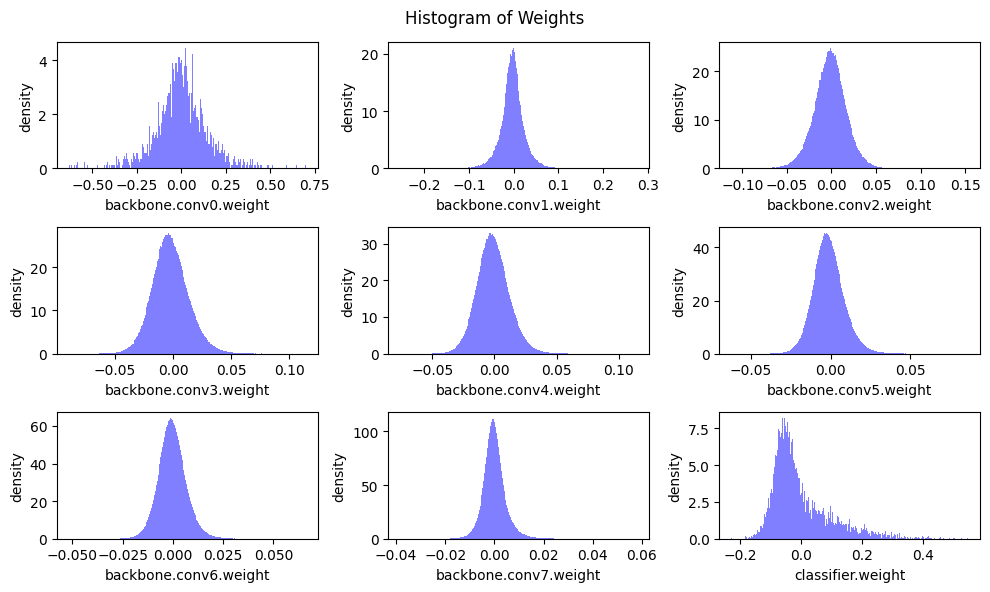

In [8]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    """가중치 분포를 시각화하는 함수

    Args:
        model: 분석할 모델
        bins: 히스토그램의 구간 수 (기본값: 256)
        count_nonzero_only: 0이 아닌 가중치만 표시할지 여부 (기본값: False)
    """
    # 3x3 서브플롯 생성
    fig, axes = plt.subplots(3, 3, figsize=(10, 6))
    axes = axes.ravel()

    plot_index = 0
    for name, param in model.named_parameters():
        # 2차원 이상의 파라미터만 처리 (Conv2d, Linear 레이어의 가중치)
        if param.dim() > 1:
            ax = axes[plot_index]

            # CPU로 데이터 이동 및 1차원으로 변환
            param_data = param.detach().view(-1).cpu()

            if count_nonzero_only:
                # 0이 아닌 값만 선택
                param_data = param_data[param_data != 0]

            # 히스토그램 그리기
            ax.hist(param_data, bins=bins, density=True,
                   color='blue', alpha=0.5)

            # 축 레이블 설정
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

이로써 실습을 위한 기본적인 준비는 모두 마무리 되었습니다.

## Reconstruction Error 계산 함수 정의

실습에 들어가기 앞서 **reconstruction error**를 계산하는 함수를 정의하겠습니다. Reconstruction error는 프루닝 전후 모델 출력의 차이를 측정하여 프루닝이 모델의 성능에 미치는 영향을 정량적으로 평가하는 지표입니다.

Input feature map $X$에 대해 원본 weight $W$와 pruning된 weight $\widehat{W}$ 사이의 reconstruction error는 다음 수식으로 계산됩니다:

${\left\Vert WX - \widehat{W}X \right\Vert}^2_2$

이 값이 작을수록 프루닝 후에도 원래 모델의 출력과 유사한 결과를 유지한다는 것을 의미합니다.

In [9]:
def get_reconstuction_error(tensor1: torch.Tensor, tensor2: torch.Tensor) -> float:
    return torch.sum((tensor1 - tensor2) ** 2).item()

# 1.1. Pruning Granularity/Pattern

이 섹션에서는 Pruning을 수행할 때 다양한 granularity(세분성)를 적용하는 방법을 배웁니다. 각 granularity는 모델의 정확도(accuracy)와 하드웨어 효율성(hardware efficiency)에 영향을 미치므로, 적절한 선택이 중요합니다.


## Pruning Granularity 소개
Pruning granularity는 Pruning이 적용되는 범위를 정의합니다. 다음과 같은 다양한 단위로 Pruning을 적용할 수 있습니다:
- **Fine-grained Pruning**: 가장 작은 단위인 개별 가중치를 대상으로 합니다.
- **Vector-level Pruning**: 가중치 벡터 단위로 Pruning을 수행합니다.
- **Kernel-level Pruning**: 컨볼루션 커널 전체를 대상으로 합니다.
- **Channel-level Pruning**: 전체 채널을 Pruning 대상으로 합니다.

각 단위는 Pruning이 모델의 구조와 성능에 미치는 영향을 다르게 하므로, 실험을 통해 각 경우의 효과를 비교해 볼 필요가 있습니다.

## Pruning Pattern의 시각화
다음 그림은 다양한 Pruning pattern을 보여줍니다. 이를 통해 각 Pruning 기법의 특징을 시각적으로 이해할 수 있습니다.

![Pruning Granularity](https://github.com/SKKU-ESLAB/pytorch-models/blob/main/pruning_granularity.png?raw=true)

본 실습에서는 가중치의 크기(Magnitude)를 기준으로 하는 중요도 점수를 사용합니다. Sparsity를 0.5로 설정하여 `model.backbone.conv1.weight`의 50%에 해당하는 가중치를 제거(Pruning)합니다. 이는 가중치의 절반을 0으로 만들어 모델을 희소화하는 과정입니다.

In [10]:
prune_sparsity = 0.5
weight = model.backbone.conv1.weight
print(weight.shape)

torch.Size([128, 64, 3, 3])


## 가중치 분포 시각화

Pruning을 수행하기 전에 가중치의 분포를 시각화하여 중요한 가중치들을 파악하고 Pruning이 미치는 영향을 분석합니다. 아래 함수를 통해 가중치의 분포를 시각적으로 확인할 수 있습니다:

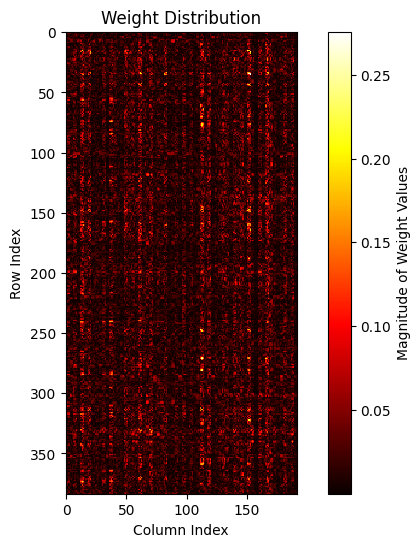

In [11]:
def draw_weight_distribution(weight_tensor, title="Weight Distribution"):
    weights = weight_tensor.detach().cpu().numpy()

    # 4D 텐서인 경우 2D로 재구성
    if len(weights.shape) == 4:
        co, ci, kh, kw = weights.shape
        weights = weights.transpose(0, 2, 1, 3).reshape(co * kh, ci * kw)

    plt.figure(figsize=(8, 6))
    plt.imshow(weights, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Magnitude of Weight Values')
    plt.title(title)
    plt.xlabel("Column Index")
    plt.ylabel("Row Index")
    plt.show()

# 가중치의 절댓값 분포 시각화
draw_weight_distribution(weight.abs())

## [실습 1] Fine-grained Pruning 구현

Fine-grained Pruning은 신경망의 가중치를 개별적으로 제거하는 기법입니다. 각 가중치의 크기(Magnitude)를 기준으로 중요도를 평가하고, 지정된 희소도(sparsity)에 따라 중요도가 낮은 가중치들을 0으로 만듭니다. 이를 통해 모델의 크기를 줄이고 연산량을 감소시킬 수 있습니다.

아래 빈칸을 채워 `prune_weight_fine_grained` 함수를 완성하세요.

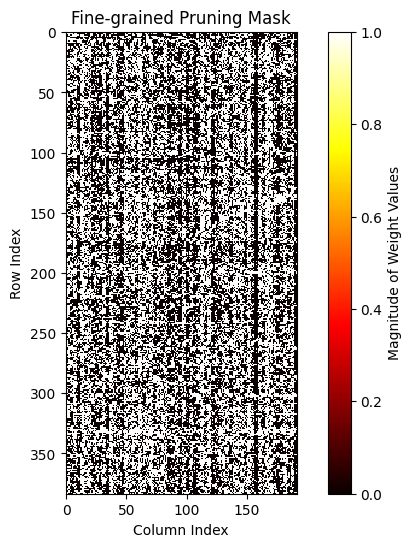

In [13]:
def prune_weight_fine_grained(weight: torch.Tensor, sparsity: float) -> None:
    """가중치 텐서에 대해 fine-grained pruning을 수행하는 함수

    Args:
        weight: pruning할 가중치 텐서
        sparsity: pruning할 비율 (0~1 사이 값)

    Returns:
        pruning mask 텐서
    """
    # sparsity 값을 0~1 사이로 제한
    sparsity = min(1.0, max(0.0, sparsity))

    # 특수한 경우 처리
    if sparsity == 1.0:  # 모든 가중치를 제거
        weight.zero_()
        return torch.zeros_like(weight)
    elif sparsity == 0.0:  # 모든 가중치를 유지
        return torch.ones_like(weight)

    ##################### YOUR CODE STARTS HERE #####################
    # 제거할 원소 개수를 계산하세요.
    # hint: round() 함수를 사용하세요.
    num_pruned_elements = round(sparsity * weight.numel())

    # 가중치의 중요도를 절댓값으로 importance 계산
    # hint: torch.abs() 함수를 사용하세요.
    importance = torch.abs(weight)

    # pruning trheshold를 계산하세요.
    # hint: torch.kthvalue() 함수를 사용하세요.
    threshold, _ = torch.kthvalue(importance.flatten(), num_pruned_elements)

    # threshold보다 큰 값들은 유지(1), 작은 값들은 제거(0)하는 마스크 생성
    # hint: 부등호를 사용하세요.
    mask = importance > threshold
    ##################### YOUR CODE ENDS HERE #######################

    # 마스크를 적용하여 pruning 수행
    weight.mul_(mask)

    return mask

# 마스크 생성 및 시각화
mask_fine_grained = prune_weight_fine_grained(weight.clone(), prune_sparsity)
draw_weight_distribution(mask_fine_grained, title="Fine-grained Pruning Mask")

## Vector-level Pruning

Vector-level Pruning은 가중치 벡터 단위로 Pruning을 수행하는 기법입니다. 이 방법은 fine-grained Pruning과 비교했을 때 구조적인 정보를 더 잘 보존할 수 있다는 장점이 있습니다. 각 가중치 벡터의 L1 norm(절대값의 합)을 기준으로 중요도를 평가하고, 중요도가 낮은 벡터들을 제거함으로써 Pruning을 수행합니다. 이러한 방식으로 네트워크의 구조적 특성을 유지하면서 모델을 경량화할 수 있습니다.

In [ ]:
def prune_weight_vector_level(weight: torch.Tensor, sparsity: float) -> None:
    """벡터 단위로 가중치를 프루닝하는 함수입니다.

    Args:
        weight: 프루닝할 가중치 텐서
        sparsity: 프루닝할 비율 (0~1 사이 값)

    Returns:
        프루닝 마스크 텐서
    """
    # sparsity 값을 0~1 사이로 제한
    sparsity = min(1.0, max(0.0, sparsity))

    # 특수한 경우 처리
    if sparsity == 1.0:  # 모든 가중치를 제거
        weight.zero_()
        return torch.zeros_like(weight)
    elif sparsity == 0.0:  # 모든 가중치를 유지
        return torch.ones_like(weight)

    # 제거할 벡터의 개수 계산
    num_vectors = weight.shape[0] * weight.shape[1] * weight.shape[2]
    num_pruned_vectors = round(num_vectors * sparsity)

    # 각 벡터의 중요도를 절댓값 합으로 계산
    importance = weight.abs().sum(dim=(3,), keepdim=True)

    # pruning trheshold를 계산
    threshold = torch.kthvalue(importance.flatten(), num_pruned_vectors)[0]

    # threshold보다 큰 벡터는 유지(1), 작은 벡터는 제거(0)
    mask = importance > threshold

    # 마스크를 가중치와 동일한 크기로 확장
    mask = mask.expand_as(weight)

    # 마스크를 적용하여 프루닝 수행
    weight.mul_(mask)

    return mask

mask_vector_level = prune_weight_vector_level(weight.clone(), prune_sparsity)
draw_weight_distribution(mask_vector_level, title="Vector-level Pruning Mask")

## Kernel-level Pruning

Kernel-level Pruning은 컨볼루션 커널을 기준으로 프루닝을 수행하는 방법입니다. 벡터 단위 프루닝보다 더 큰 구조적 단위로 프루닝을 수행하기 때문에 하드웨어 가속과 연산 최적화에 더 효과적입니다. 각 커널의 가중치 절댓값 총합을 중요도로 사용하여 불필요한 커널을 제거합니다.

In [ ]:
def prune_weight_kernel_level(weight: torch.Tensor, sparsity: float) -> None:
    """커널 단위로 가중치를 프루닝하는 함수

    Args:
        weight: 프루닝할 가중치 텐서 (out_channels, in_channels, kernel_h, kernel_w)
        sparsity: 프루닝할 비율 (0~1 사이 값)

    Returns:
        프루닝 마스크 텐서
    """
    sparsity = min(1.0, max(0.0, sparsity))
    if sparsity == 1.0:
        weight.zero_()
        return torch.zeros_like(weight)
    elif sparsity == 0.0:
        return torch.ones_like(weight)

    # 프루닝할 커널 수 계산
    num_kernels = weight.shape[0] * weight.shape[1]
    num_pruned_kernels = round(num_kernels * sparsity)

    # 각 커널의 중요도를 절댓값 합으로 계산 (커널 크기에 대해 합산)
    importance = weight.abs().sum(dim=(2, 3), keepdim=True)

    # pruning trheshold를 계산
    threshold = torch.kthvalue(importance.flatten(), num_pruned_kernels)[0]

    # threshold보다 큰 커널은 유지(1), 작은 커널은 제거(0)
    mask = importance > threshold

    # 마스크를 가중치와 동일한 크기로 확장
    mask = mask.expand_as(weight)

    # 마스크를 적용하여 프루닝 수행
    weight.mul_(mask)

    return mask

mask_kernel_level = prune_weight_kernel_level(weight.clone(), prune_sparsity)
draw_weight_distribution(mask_kernel_level, title="Kernel-level Pruning Mask")

## Channel-level Pruning

Channel-level Pruning은 입력 또는 출력 채널 전체를 Pruning 대상으로 합니다.
채널 단위로 프루닝을 수행하면 해당 채널과 관련된 모든 연산이 제거되므로 모델의 효율성을 향상시킬 수 있습니다.

In [ ]:
def prune_weight_channel_level(weight: torch.Tensor, sparsity: float) -> None:
    """채널 단위 프루닝을 수행하는 함수

    Args:
        weight: 프루닝할 가중치 텐서 (out_channels, in_channels, kernel_h, kernel_w)
        sparsity: 프루닝할 비율 (0~1 사이 값)

    Returns:
        프루닝 마스크 텐서
    """
    sparsity = min(1.0, max(0.0, sparsity))
    if sparsity == 1.0:
        weight.zero_()
        return torch.zeros_like(weight)
    elif sparsity == 0.0:
        return torch.ones_like(weight)

    # 프루닝할 채널 수 계산
    num_channels = weight.shape[1]
    num_pruned_channels = round(num_channels * sparsity)

    # 각 채널의 중요도를 절댓값 합으로 계산
    # (출력 채널, 커널 높이, 커널 너비에 대해 합산)
    importance = weight.abs().sum(dim=(0, 2, 3), keepdim=True)

    # pruning threshold를 계산
    threshold = torch.kthvalue(importance.flatten(), num_pruned_channels)[0]

    # threshold보다 큰 채널은 유지(1), 작은 채널은 제거(0)
    mask = importance > threshold

    # 마스크를 가중치와 동일한 크기로 확장
    mask = mask.expand_as(weight)

    # 마스크를 적용하여 프루닝 수행
    weight.mul_(mask)

    return mask

mask_channel_level = prune_weight_channel_level(weight.clone(), prune_sparsity)
draw_weight_distribution(mask_channel_level, title="Channel-level Pruning Mask")

## 중요도 합 비교

각 프루닝 기법에 따라 제거된 가중치의 중요도 합을 비교합니다. 이를 통해 각 프루닝 방법이 얼마나 중요한 가중치를 제거하는지 파악할 수 있습니다. 중요도가 높은 가중치를 많이 제거할수록 모델의 성능 저하가 클 것으로 예상됩니다.

In [ ]:
# 가중치의 중요도를 절댓값으로 계산
importance = weight.abs()

# 각 프루닝 방법별 중요도 합 계산
importance_sum = importance.sum().item()  # 원본
importance_sum_fine_grained = (importance * mask_fine_grained).sum().item()  # 미세 단위
importance_sum_vector_level = (importance * mask_vector_level).sum().item()  # 벡터 단위
importance_sum_kernel_level = (importance * mask_kernel_level).sum().item()  # 커널 단위
importance_sum_channel_level = (importance * mask_channel_level).sum().item()  # 채널 단위

plt.figure(figsize=(8, 6))
plt.bar(['Original', 'Fine-grained', 'Vector-level', 'Kernel-level', 'Channel-level'],
        [importance_sum, importance_sum_fine_grained, importance_sum_vector_level,
         importance_sum_kernel_level, importance_sum_channel_level])
plt.ylabel('Importance Sum')
plt.title('Importance Sum of Different Pruning Methods')
plt.show()

## Reconstruction Error 비교

각 Pruning 기법을 적용한 후, 모델 출력의 reconstruction error를 비교합니다. 이를 통해 각 Pruning 방법이 모델의 출력에 미치는 영향을 정량적으로 평가할 수 있습니다. Reconstruction error가 클수록 원본 모델의 출력과 더 많이 달라졌음을 의미하며, 이는 해당 Pruning 방법이 모델의 성능에 더 큰 영향을 미칠 수 있음을 나타냅니다.

In [ ]:
# 랜덤 입력 샘플 생성
input_sample = torch.randn(1, 64, 32, 32, device=weight.device)

# 원본 컨볼루션 레이어 생성 및 출력 계산
conv_original = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False, device=weight.device)
conv_original.weight.data = weight.clone()
output_original = conv_original(input_sample)

# Fine-grained 프루닝 적용 및 재구성 오차 계산
conv_pruned_fine_grained = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False, device=weight.device)
conv_pruned_fine_grained.weight.data = weight.clone() * mask_fine_grained
output_pruned_fine_grained = conv_pruned_fine_grained(input_sample)
reconstruction_error_fine_grained = get_reconstuction_error(output_original, output_pruned_fine_grained)

# Vector-level 프루닝 적용 및 재구성 오차 계산
conv_pruned_vector_level = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False, device=weight.device)
conv_pruned_vector_level.weight.data = weight.clone() * mask_vector_level
output_pruned_vector_level = conv_pruned_vector_level(input_sample)
reconstruction_error_vector_level = get_reconstuction_error(output_original, output_pruned_vector_level)

# Kernel-level 프루닝 적용 및 재구성 오차 계산
conv_pruned_kernel_level = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False, device=weight.device)
conv_pruned_kernel_level.weight.data = weight.clone() * mask_kernel_level
output_pruned_kernel_level = conv_pruned_kernel_level(input_sample)
reconstruction_error_kernel_level = get_reconstuction_error(output_original, output_pruned_kernel_level)

# Channel-level 프루닝 적용 및 재구성 오차 계산
conv_pruned_channel_level = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False, device=weight.device)
conv_pruned_channel_level.weight.data = weight.clone() * mask_channel_level
output_pruned_channel_level = conv_pruned_channel_level(input_sample)
reconstruction_error_channel_level = get_reconstuction_error(output_original, output_pruned_channel_level)

# Reconstruction error 시각화
plt.figure(figsize=(8, 6))
plt.bar(['Fine-grained', 'Vector-level', 'Kernel-level', 'Channel-level'],
        [reconstruction_error_fine_grained, reconstruction_error_vector_level,
         reconstruction_error_kernel_level, reconstruction_error_channel_level])
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of Different Pruning Methods')
plt.show()

# 1.2. Pruning Ratio

- Layer별 민감도(Sensitivity) 분석
    - 각 레이어의 중요도를 파악하기 위해 특정 레이어만 sparsity를 변화시키면서 정확도 변화를 측정
    - 이를 통해 pruning에 민감한 레이어와 덜 민감한 레이어를 파악

- Non-uniform vs Uniform Pruning 비교
    - Uniform: 모든 레이어에 동일한 pruning ratio 적용
    - Non-uniform: 레이어별 민감도에 따라 global threshold 기반으로 다른 pruning ratio 적용 
    - 두 방식 간의 정확도와 모델 크기의 trade-off 비교 분석

## Sensitivity 분석

각 레이어의 민감도를 분석하기 위해 다른 레이어는 고정한 상태에서 특정 레이어의 sparsity를 변화시키며 정확도 변화를 측정합니다. 이를 통해 각 레이어가 pruning에 얼마나 민감한지 파악할 수 있습니다.

In [14]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    """
    각 레이어의 민감도를 분석하기 위한 함수

    Args:
        model: 분석할 모델
        dataloader: 평가에 사용할 데이터로더
        scan_step: sparsity 증가 단위
        scan_start: 시작 sparsity
        scan_end: 종료 sparsity
        verbose: 상세 출력 여부

    Returns:
        sparsities: 테스트한 sparsity 값들
        accuracies: 각 레이어별 sparsity에 따른 정확도
    """
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []

    # 합성곱 레이어의 가중치만 선택
    named_conv_weights = [(name, param) for (name, param) \
                         in model.named_parameters() if param.dim() > 1]

    # 각 레이어별로 민감도 스캔 수행
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()  # 원본 가중치 백업
        accuracy = []

        # 각 sparsity 레벨에서 pruning 수행하고 정확도 측정
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            prune_weight_fine_grained(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)

            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: ' + \
                  f'accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')

        accuracies.append(accuracy)

    return sparsities, accuracies

# 민감도 분석 실행
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.41%, 31.81%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.31%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.87%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.19%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.86%, 92.65%, 92.10%, 90.58%, 83.65%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.92%, 92.88%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.81%, 92.97%, 92.68%, 92.52%]

각 레이어별 sparsity 변화에 따른 정확도를 시각화하여 sensitivity를 분석합니다.
아래 그래프는 각 레이어의 sparsity 변화에 따른 정확도 변화를 보여주며,
이를 통해 각 레이어의 pruning 민감도를 파악할 수 있습니다.


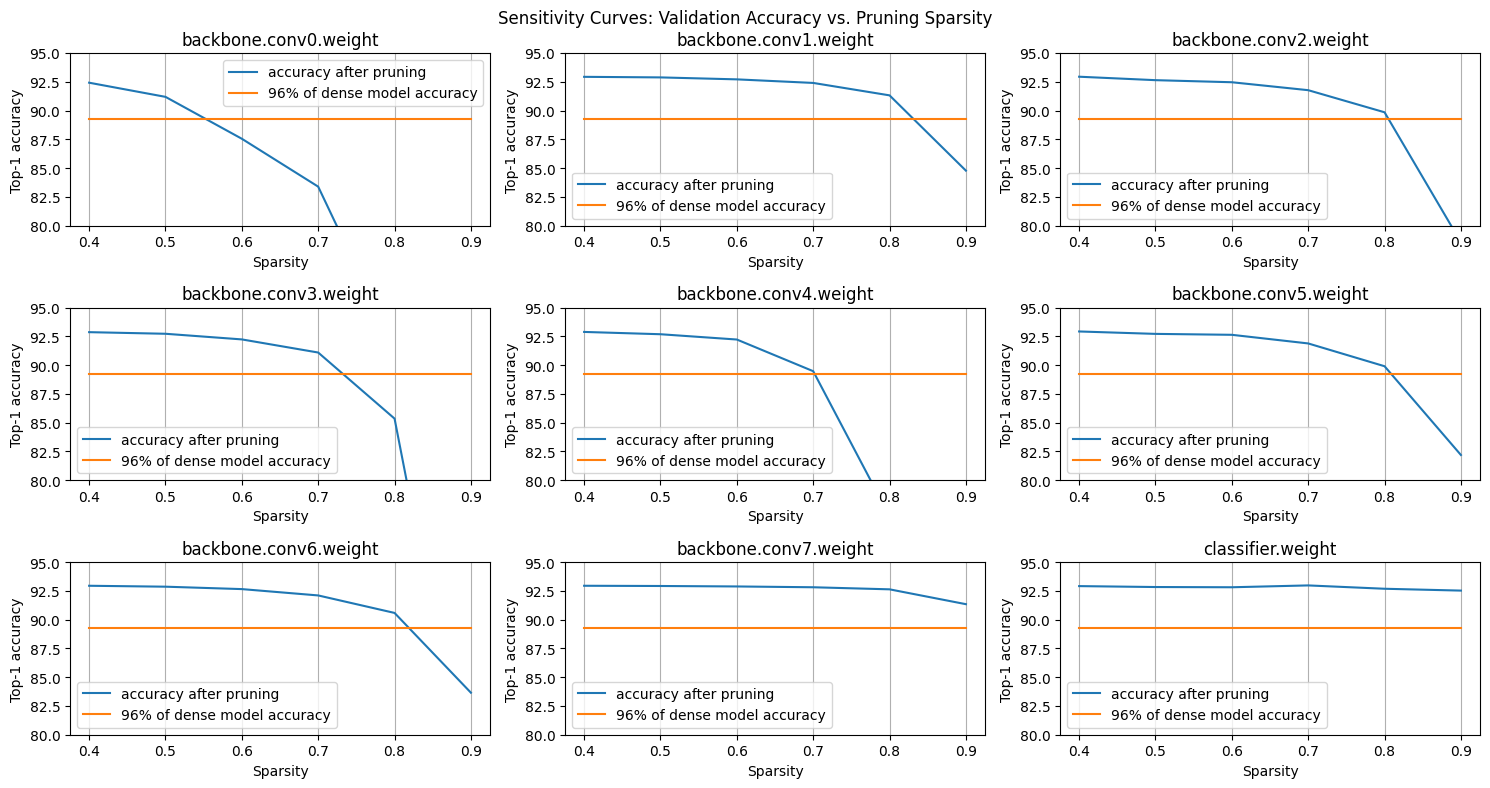

In [15]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    """민감도 스캔 결과를 시각화하는 함수"""
    lower_bound_accuracy = dense_model_accuracy * 0.96  # 기준 정확도의 96%를 하한선으로 설정

    # 서브플롯 생성
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)), figsize=(15, 8))
    axes = axes.ravel()

    # 각 레이어별 민감도 곡선 그리기
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:  # Convolution/Linear 레이어만 선택
            ax = axes[plot_index]

            # 민감도 곡선과 하한선 그리기
            ax.plot(sparsities, accuracies[plot_index], label='accuracy after pruning')
            ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities),
                   label=f'{lower_bound_accuracy/dense_model_accuracy*100:.0f}% of dense model accuracy')

            # 축과 레이블 설정
            ax.set_xticks(np.arange(0.4, 1.0, 0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('Sparsity')
            ax.set_ylabel('Top-1 accuracy')
            ax.legend()
            ax.grid(axis='x')

            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

## [실습 2] Sensitivity Analysis를 통한 Pruning 수행

Sensitivity analysis 결과를 바탕으로 각 레이어별 sparsity를 `custom_sparsity_dict`에 입력하세요.

위 그래프의 분석 결과를 토대로 아래와 같이 진행하면 됩니다다:
- 정확도 하락이 적은 레이어: 높은 sparsity 값 설정 
- 정확도 하락이 큰 레이어: 낮은 sparsity 값 설정

이러한 레이어별 차등적인 pruning을 통해 모델의 전반적인 성능은 유지하면서 효율적인 압축을 달성하는 것이 목표입니다.

In [16]:
class FineGrainedPruner:
    """Fine-grained pruning을 수행하는 클래스"""
    def __init__(self, model, sparsity_dict):
        """
        Args:
            model: pruning할 모델
            sparsity_dict: 레이어별 희소성 비율을 담은 딕셔너리
        """
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        """마스크를 모델에 적용"""
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        """
        모델의 각 레이어에 대해 희소성 비율에 따라 가지치기 수행

        Args:
            model: 가지치기할 모델
            sparsity_dict: 레이어별 희소성 비율을 담은 딕셔너리

        Returns:
            masks: 레이어별 마스크를 담은 딕셔너리
        """
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = prune_weight_fine_grained(param, sparsity_dict[name])
        return masks

def get_uniform_sparsity_dict(sparsity):
    """
    모든 레이어에 동일한 희소성 비율을 적용하는 딕셔너리 생성

    Args:
        sparsity: 적용할 희소성 비율

    Returns:
        sparsity_dict: 레이어별 동일한 희소성 비율을 담은 딕셔너리
    """
    sparsity_dict = {name: sparsity for name, param in model.named_parameters() if param.dim() > 1}
    return sparsity_dict

In [17]:
def get_model_sparsity(model: nn.Module) -> float:
    """
    모델 전체의 sparsity 계산.

    Args:
        model: 스파시티를 계산할 모델

    Returns:
        float: 모델의 전체 스파시티 비율 (0~1 사이 값)
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

custom_sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # Key는 수정하지 마시고, 각 layer의 sparsity 값을 조정하세요.
    'backbone.conv0.weight': 0.5,
    'backbone.conv1.weight': 0.8,
    'backbone.conv2.weight': 0.7,
    'backbone.conv3.weight': 0.7,
    'backbone.conv4.weight': 0.6,
    'backbone.conv5.weight': 0.7,
    'backbone.conv6.weight': 0.8,
    'backbone.conv7.weight': 0.9,
    'classifier.weight': 0.9 
##################### YOUR CODE ENDS HERE #######################
}

# 프루닝 적용 및 평가
pruner = FineGrainedPruner(model, custom_sparsity_dict)
pruner.apply(model)
custom_pruned_model_accuracy = evaluate(model, dataloader['test'])
custom_sparsity = get_model_sparsity(model)
model.recover_model()

# 결과 출력
print(f"custom_pruned_model has accuracy={custom_pruned_model_accuracy:.2f}%")
print(f"Model sparsity: {custom_sparsity:.3f}")

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

custom_pruned_model has accuracy=78.39%
Model sparsity: 0.764


Sensitivity analysis를 통한 pruning 결과와 비교하기 위해 모든 레이어에 uniform sparsity를 적용했을 때의 accuracy를 측정합니다.

In [18]:
# 균일한 sparsity 값들을 생성 (0.4부터 0.9까지 0.1 간격)
uniform_sparsities = np.arange(start=0.4, stop=1.0, step=0.1)
accuracies = []

# 각 sparsity 값에 대해 프루닝 수행 및 정확도 측정
for sparsity in uniform_sparsities:
    # 균일한 sparsity로 프루너 생성 및 적용
    pruner = FineGrainedPruner(model, get_uniform_sparsity_dict(sparsity))
    pruner.apply(model)

    # 테스트셋에서 정확도 평가
    accuracy = evaluate(model, dataloader['test'], verbose=False)
    accuracies.append(accuracy)

    # 모델 복구
    model.recover_model()

    # 결과 출력
    print(f"uniform sparsity={sparsity:.2f}: accuracy={accuracy:.2f}%")

uniform sparsity=0.40: accuracy=92.10%
uniform sparsity=0.50: accuracy=90.66%
uniform sparsity=0.60: accuracy=87.25%
uniform sparsity=0.70: accuracy=75.80%
uniform sparsity=0.80: accuracy=41.11%
uniform sparsity=0.90: accuracy=14.57%


Layer-wise pruning(uniform sparsity)와 global pruning(sensitivity analysis) 방식의 정확도를 비교하는 그래프입니다.

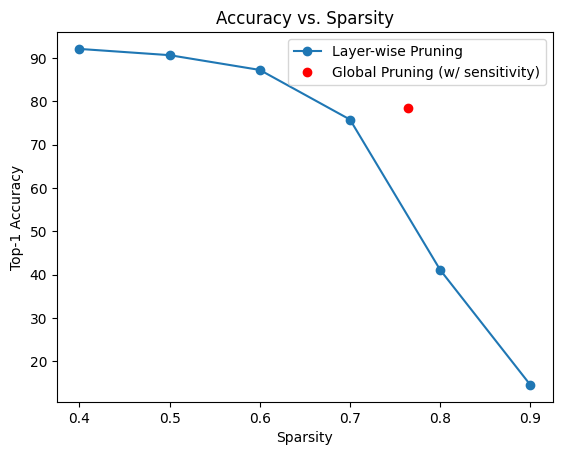

In [19]:
plt.plot(uniform_sparsities, accuracies, 'o-', label="Layer-wise Pruning")
plt.plot([custom_sparsity], [custom_pruned_model_accuracy], 'ro', label='Global Pruning (w/ sensitivity)')
plt.xlabel('Sparsity')
plt.ylabel('Top-1 Accuracy')
plt.title('Accuracy vs. Sparsity')
plt.legend()
plt.show()

## [실습 3] Global Magnitude Pruning 구현

이 실습에서는 Global Magnitude Pruning을 구현합니다. Global Magnitude Pruning은 모델의 모든 가중치를 하나의 집합으로 간주하고, 가중치의 절대값을 기준으로 중요도를 평가하여 전체 모델에서 가장 작은 가중치를 제거하는 방식입니다. 이는 각 레이어별로 균일한 비율로 프루닝하는 것이 아니라, 전체 모델에서 가중치의 크기에 따라 프루닝을 수행합니다.

**구현 과정:**
1. 모든 레이어의 가중치를 하나의 벡터로 통합
2. 가중치의 절대값으로 중요도 계산
3. 프루닝 비율에 따른 임계값 설정
4. 임계값 미만의 가중치를 제거하는 마스크 생성 및 적용

이러한 방식으로 모델의 파라미터를 효율적으로 줄이면서도 중요한 정보는 보존할 수 있습니다. 결과적으로 모델 크기와 연산량을 감소시키면서 성능 저하를 최소화하는 것이 목표입니다.

아래 빈칸을 채워 `FineGrainedPrunerV2` 클래스를 완성하세요.

In [21]:
class FineGrainedPrunerV2:
    def __init__(self, model, sparsity, global_prune=False):
        """
        전역 또는 레이어별 프루닝을 위한 프루너 클래스

        Args:
            model: 프루닝할 모델
            sparsity: 프루닝 비율 (0~1)
            global_prune: 전역 프루닝 여부
        """
        self.masks = FineGrainedPrunerV2.prune(model, sparsity, global_prune)

    @torch.no_grad()
    def apply(self, model):
        """프루닝 마스크를 모델에 적용"""
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity, global_prune):
        """
        전역 또는 레이어별 프루닝 수행

        Args:
            model: 프루닝할 모델
            sparsity: 프루닝 비율 (0~1)
            global_prune: 전역 프루닝 여부

        Returns:
            masks: 프루닝 마스크 딕셔너리
        """
        masks = dict()
        if global_prune:
            # 모든 2D 이상의 파라미터를 1차원으로 변환하여 수집
            parameters_to_prune = []
            for name, param in model.named_parameters():
                if param.dim() > 1:  # conv, fc 레이어만 프루닝
                    parameters_to_prune.append(param.view(-1))

            ##################### YOUR CODE STARTS HERE #####################
            # 모든 weight를 하나의 텐서로 결합해주세요..
            # hint: torch.cat()을 사용하세요.
            all_weights = torch.cat(parameters_to_prune)

            # all_weights를 대상으로 global threshold를 구해주세요.
            num_elements = all_weights.numel()
            num_zeros = round(num_elements * sparsity)
            importance = torch.abs(all_weights)
            threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
            ##################### YOUR CODE ENDS HERE #######################

            # threshold 기반 마스크 생성
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    mask = torch.abs(param.data) > threshold
                    masks[name] = mask
        else:
            # 레이어별 프루닝 수행
            for name, param in model.named_parameters():
                if param.dim() > 1: # we only prune conv and fc weights
                    masks[name] = prune_weight_fine_grained(param, sparsity)
        return masks

In [22]:
# Golbal Magnitude Pruning 수행
pruner = FineGrainedPrunerV2(model, custom_sparsity, global_prune=True)
pruner.apply(model)

# 프루닝된 모델의 정확도 평가
global_magnitude_pruned_model_accuracy = evaluate(model, dataloader['test'])

# 모델 복구
model.recover_model()

# 결과 출력
print(f"global_magnitude_pruned_model has accuracy={global_magnitude_pruned_model_accuracy:.2f}%")

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

global_magnitude_pruned_model has accuracy=82.13%


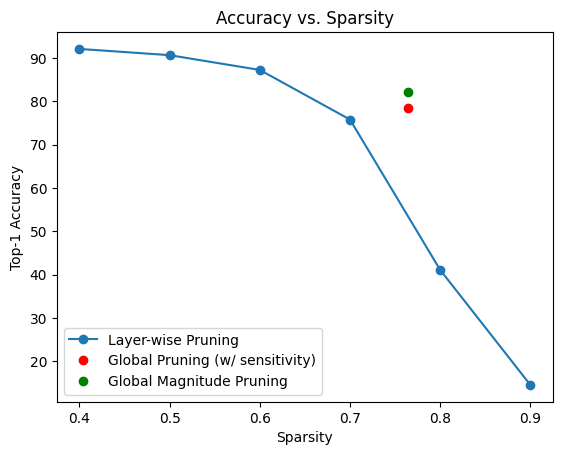

In [23]:
plt.plot(uniform_sparsities, accuracies, 'o-', label="Layer-wise Pruning")
plt.plot([custom_sparsity], [custom_pruned_model_accuracy], 'ro', label='Global Pruning (w/ sensitivity)')
plt.plot([custom_sparsity], [global_magnitude_pruned_model_accuracy], 'go', label='Global Magnitude Pruning')
plt.xlabel('Sparsity')
plt.ylabel('Top-1 Accuracy')
plt.title('Accuracy vs. Sparsity')
plt.legend()
plt.show()

Global magnitude pruning 방식으로 pruning한 모델의 정확도를 다른 pruning 방식과 비교 분석합니다.
Layer-wise pruning, Global pruning (sensitivity 기반), Global magnitude pruning 세 방식의 성능을 비교하여 각 방식의 특징을 비교합니다.

In [24]:
global_magnitude_pruned_model_accuracies = []
for sparsity in uniform_sparsities:
    pruner = FineGrainedPrunerV2(model, sparsity, global_prune=True)
    pruner.apply(model)
    accuracy = evaluate(model, dataloader['test'], verbose=False)
    global_magnitude_pruned_model_accuracies.append(accuracy)
    model.recover_model()
    print(f"global magnitude sparsity={sparsity:.2f}: accuracy={accuracy:.2f}%")

global magnitude sparsity=0.40: accuracy=92.83%
global magnitude sparsity=0.50: accuracy=92.67%
global magnitude sparsity=0.60: accuracy=92.25%
global magnitude sparsity=0.70: accuracy=89.97%
global magnitude sparsity=0.80: accuracy=69.00%
global magnitude sparsity=0.90: accuracy=18.21%


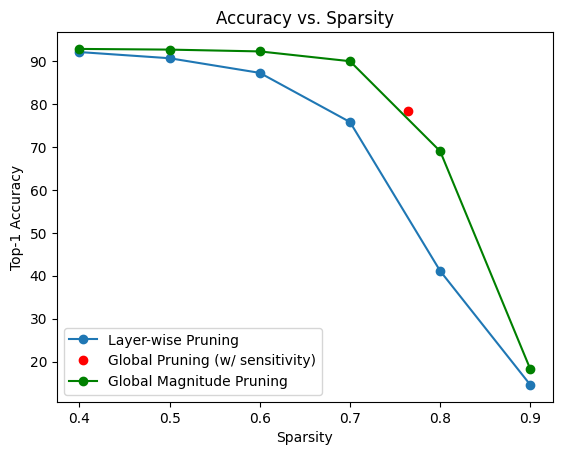

In [25]:
plt.plot(uniform_sparsities, accuracies, 'o-', label="Layer-wise Pruning")
plt.plot([custom_sparsity], [custom_pruned_model_accuracy], 'ro', label='Global Pruning (w/ sensitivity)')
plt.plot(uniform_sparsities, global_magnitude_pruned_model_accuracies, 'go-', label='Global Magnitude Pruning')
plt.xlabel('Sparsity')
plt.ylabel('Top-1 Accuracy')
plt.title('Accuracy vs. Sparsity')
plt.legend()
plt.show()

# 1.3. Pruning Schedule

이 섹션에서는 Pruning 스케줄링을 구현하고, 모델의 Fine-tuning과 함께 Pruning을 진행합니다. Pruning 스케줄링은 모델 학습 중 특정 시점에 가중치를 제거하는 체계적인 접근 방식입니다. 이를 통해 모델의 학습 과정에서 점진적으로 Pruning을 적용하여 성능 저하를 최소화하면서 모델 크기를 효과적으로 줄일 수 있습니다.

**주요 Pruning 스케줄 방식:**
- **One-shot Pruning**: 목표 Pruning 비율을 한 번에 적용한 후, Fine-tuning으로 성능을 회복합니다.
- **Iterative Pruning**: 여러 단계에 걸쳐 점진적으로 Pruning을 수행합니다. 각 단계마다 일정 비율의 가중치를 제거하고 학습을 통해 모델이 새로운 구조에 적응하도록 합니다.

**Iterative Pruning의 스케줄링 방법:**
- **Linear Sparsity Scheduler**: Pruning 비율을 시간에 따라 선형적으로 증가시킵니다.
- **Cubic Sparsity Scheduler**: Pruning 비율을 시간에 따라 세제곱 비율로 증가시켜, 초기에는 급격하게, 후반에는 완만하게 증가시킵니다.

이러한 스케줄러들은 모델이 Pruning에 점진적으로 적응할 수 있게 하여, 최종적으로 원래의 성능을 최대한 유지할 수 있도록 합니다. Pruning 스케줄은 모델의 특성과 요구사항에 맞춰 조정될 수 있으며, 이를 통해 모델의 성능과 효율성의 균형을 맞출 수 있습니다.

## One-shot Pruning

실습 3에서 구현한 `FineGrainedPrunerV2`를 사용하여 One-shot Pruning을 구현합니다.
목표 sparsity를 95%로 설정하고 5 epoch 동안 fine-tuning을 진행합니다.

학습에 사용되는 주요 구성 요소:
- Optimizer: SGD (learning rate=0.01, momentum=0.9, weight_decay=1e-4)
- Scheduler: CosineAnnealingLR
- Loss function: CrossEntropyLoss

In [26]:
num_finetune_epochs = 5
target_sparsity = 0.95
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs * len(dataloader['train']))
criterion = nn.CrossEntropyLoss()

pruner = FineGrainedPrunerV2(model, target_sparsity, global_prune=True)

print(f"Finetuning Fine-grained Pruned Sparse Model")
for epoch in range(num_finetune_epochs):
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    print(f"   Epoch {epoch+1}/{num_finetune_epochs}: accuracy={accuracy:.2f}%")
model.recover_model()

Finetuning Fine-grained Pruned Sparse Model


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 1/5: accuracy=89.75%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 2/5: accuracy=90.48%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 3/5: accuracy=90.83%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 4/5: accuracy=90.90%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 5/5: accuracy=90.99%


## [실습 4] Sparsity Scheduler 구현

이 실습에서는 시간에 따른 Pruning 비율을 조절하는 다음 2가지 Sparsity Scheduler를 구현합니다:
- **Linear sparsity scheduler**: $v^{(t)} = v_f + \left(v_i - v_f\right)\left(1 - \frac{t - t_i}{t_f - t_i}\right)$
    - 시간에 따라 선형적으로 sparsity가 증가
- **Cubic sparsity scheduler**: $v^{(t)} = v_f + \left(v_i - v_f\right)\left(1 - \frac{t - t_i}{t_f - t_i}\right)^3$
    - 시간에 따라 세제곱 비율로 sparsity가 증가

아래 빈 칸을 채워 `get_sparsity_schedule` 함수를 완성하세요.

In [32]:
def get_sparsity_schedule(num_epochs: int,
                          epoch_start: int,
                          epoch_end: int,
                          sparsity_start: float,
                          sparsity_end: float,
                          exponent: int,
                          ) -> List[float]:
    """
    스파시티 스케줄을 생성하는 함수입니다.

    Args:
        num_epochs: 전체 에폭 수
        epoch_start: 스파시티 스케줄링 시작 에폭
        epoch_end: 스파시티 스케줄링 종료 에폭
        sparsity_start: 시작 스파시티 값
        sparsity_end: 종료 스파시티 값
        exponent: 스케줄링 지수 (1: linear, 3: cubic)

    Returns:
        각 에폭별 스파시티 값 리스트
    """
    sparsity_schedule = []
    ##################### YOUR CODE STARTS HERE #####################
    for epoch in range(num_epochs):
        # 위 수식에 맞게 sparsity를 계산하세요. (단, epoch_start보다 작은 경우 0으로 epochs_end 이후는 sparsity_end로 설정합니다.)
        if epoch < epoch_start:
            sparsity = sparsity_start
        elif epoch >= epoch_end:
            sparsity = sparsity_end
        else:
            sparsity = sparsity_end + (sparsity_start - sparsity_end) * (1 - (epoch - epoch_start) / (epoch_end - epoch_start)) ** exponent

        sparsity_schedule.append(sparsity)
    ##################### YOUR CODE ENDS HERE #######################
    return sparsity_schedule

# Linear sparsity schedule
# linear_sparsity_schedule = [0.9, 0.925, 0.95, 0.95, 0.95]
linear_sparsity_schedule = get_sparsity_schedule(num_finetune_epochs, 0, 2, 0.9, target_sparsity, 1)
print("Linear sparsity schedule:", linear_sparsity_schedule)

# Cubic sparsity schedule
# cubic_sparsity_schedule = [0.9, 0.94375, 0.95, 0.95, 0.95]
cubic_sparsity_schedule = get_sparsity_schedule(num_finetune_epochs, 0, 2, 0.9, target_sparsity, 3)
print("Cubic sparsity schedule:", cubic_sparsity_schedule)

Linear sparsity schedule: [0.9, 0.925, 0.95, 0.95, 0.95]
Cubic sparsity schedule: [0.9, 0.94375, 0.95, 0.95, 0.95]


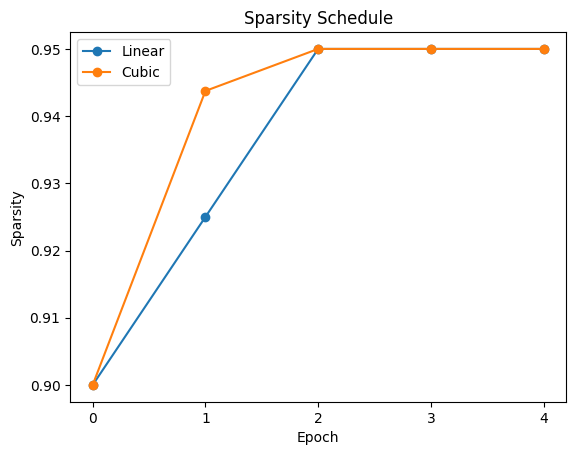

In [33]:
plt.plot(range(num_finetune_epochs), linear_sparsity_schedule, 'o-', label='Linear')
plt.plot(range(num_finetune_epochs), cubic_sparsity_schedule, 'o-', label='Cubic')
plt.xticks(np.arange(5))
plt.xlabel('Epoch')
plt.ylabel('Sparsity')
plt.title('Sparsity Schedule')
plt.legend()
plt.show()

## Iterative Pruning

Iterative Pruning은 모델의 가중치를 한 번에 제거하는 대신 여러 단계에 걸쳐 점진적으로 제거하는 방법입니다. 각 단계에서 일정 비율의 가중치를 제거한 후 모델을 재학습시켜 남은 가중치들이 제거된 가중치를 보완할 수 있도록 합니다.

이때 가중치를 제거하는 비율을 조절하는 방법으로 Linear와 Cubic Sparsity Scheduler를 사용할 수 있습니다. Cubic Scheduler는 초기에는 빠르게 가중치를 제거하다가 후반부로 갈수록 천천히 제거하는 방식을 사용합니다. 이는 모델이 후반에 중요한 가중치를 신중하게 제거할 수 있도록 시간을 더 많이 주기 때문에, Linear Scheduler에 비해 일반적으로 더 좋은 성능을 보입니다.

Linear sparsity schedule을 사용하여 iterative pruning을 수행하세요.

In [34]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs * len(dataloader['train']))
criterion = nn.CrossEntropyLoss()

print(f"Finetuning Fine-grained Pruned Sparse Model with linear sparsity scheduler")
for epoch in range(num_finetune_epochs):
    pruner = FineGrainedPrunerV2(model, linear_sparsity_schedule[epoch], global_prune=True)
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    print(f"   Epoch {epoch+1}/{num_finetune_epochs}: accuracy={accuracy:.2f}%")

model.recover_model()

Finetuning Fine-grained Pruned Sparse Model with linear sparsity scheduler


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 1/5: accuracy=91.47%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 2/5: accuracy=91.71%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 3/5: accuracy=91.04%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 4/5: accuracy=91.15%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 5/5: accuracy=91.23%


Cubic sparsity schedule을 사용하여 iterative pruning을 수행하세요.

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs * len(dataloader['train']))
criterion = nn.CrossEntropyLoss()

print(f"Finetuning Fine-grained Pruned Sparse Model with cubic sparsity scheduler")
for epoch in range(num_finetune_epochs):
    pruner = FineGrainedPrunerV2(model, cubic_sparsity_schedule[epoch], global_prune=True)
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    print(f"   Epoch {epoch+1}/{num_finetune_epochs}: accuracy={accuracy:.2f}%")

model.recover_model()

Finetuning Fine-grained Pruned Sparse Model with cubic sparsity scheduler


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 1/5: accuracy=91.70%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 2/5: accuracy=91.07%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 3/5: accuracy=91.13%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 4/5: accuracy=91.23%


Train:   0%|          | 0/98 [00:00<?, ?it/s]

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

   Epoch 5/5: accuracy=91.37%
